# Welch's t-Test for Comparing Means:
> Use Case: 
- Compare means of two independent groups with unequal variances.
> Assumptions:
- Data is approximately normally distributed.
- Homogeneity of variances is not assumed.
> Example Scenario:
- Investigating if there is a significant difference in the blood pressure levels between two different drug treatments.
> Null Hypothesis (H0):
- There is no significant difference in the means of the two groups.
> Alternative Hypothesis (H1):
- There is a significant difference in the means of the two groups.

In [18]:
import warnings

warnings.filterwarnings("ignore")

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# !pip install scipy==1.12.0
from scipy.stats import norm, levene, shapiro, ttest_ind

# !pip install pingouin==0.5.4
import pingouin as pg

In [20]:
# Set random seed for reproducibility
np.random.seed(42)

In [21]:
# set seaborn style
sns.set(style="white", palette="mako")

# colors
color = 'red'

# remove some borders    
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

### Power Analysis

In [22]:
# Welch's t-test sample size function
def welch_t_test_sample_size(mean1, mean2, sd1, sd2, alpha, power):
    """
    Approximate sample size calculation per group for Welch's t-test.

    Args:
        mean1 (float): Expected mean of group 1.
        mean2 (float): Expected mean of group 2.
        sd1 (float): Expected standard deviation of group 1.
        sd2 (float): Expected standard deviation of group 2.
        alpha (float): Desired significance level (e.g., 0.05 for 5%).
        power (float): Desired statistical power (e.g., 0.8 for 80%).

    Returns:
        int: Approximate required sample size per group.
    """
    effect_size = abs(mean1 - mean2) / np.sqrt((sd1**2 + sd2**2) / 2)
    z_alpha = norm.ppf(1 - alpha / 2)
    z_beta = norm.ppf(power)
    n = ((z_alpha + z_beta)**2 * (sd1**2 + sd2**2)) / effect_size**2
    return int(np.ceil(n))

In [23]:
# Set the parameters for the power analysis
alpha = 0.05  # Significance level
desired_power = 0.8  # Desired statistical power

# Define the range of effect sizes to test
effect_sizes = np.linspace(0.1, 0.5, 20)  # Effect sizes from 0.05 to 0.5 in 20 increments

# Assume some standard deviations for the two groups
# You might want to explore how different SDs affect the sample size
sd_group1 = 20.0
sd_group2 = 5.0

# We'll also need to estimate the means of both groups
mean_group1 = 125
mean_group2 = 118

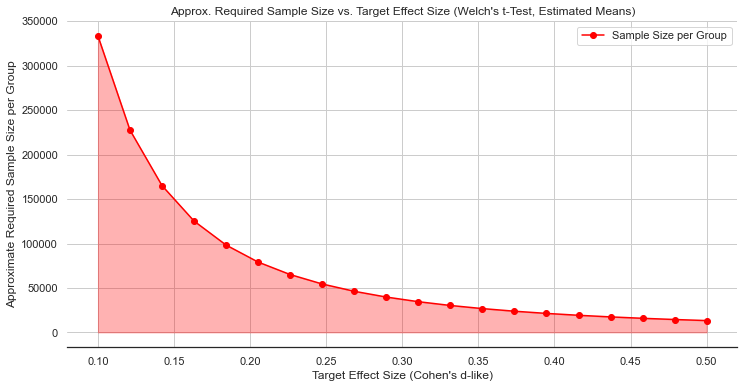

In [24]:
# Calculate the required sample size for each effect size
sample_sizes = []
for effect_size_target in effect_sizes:
    # To achieve a specific effect size with these SDs, the difference
    # between the means would need to be:
    implied_mean_difference = effect_size_target * np.sqrt((sd_group1**2 + sd_group2**2) / 2)
    # We can imagine a hypothetical mean for group 2 that would yield this difference
    # (keeping mean_group1 fixed for this illustration)
    hypothetical_mean_group2 = mean_group1 + implied_mean_difference

    sample_size = welch_t_test_sample_size(
        mean1=mean_group1,
        mean2=hypothetical_mean_group2,
        sd1=sd_group1,
        sd2=sd_group2,
        alpha=alpha,
        power=desired_power
    )
    sample_sizes.append(round(sample_size))

# Plot the effect sizes against the required sample sizes
plt.figure(figsize=(12, 6))
plt.plot(effect_sizes, sample_sizes, marker='o', linestyle='-', color=color, label='Sample Size per Group')
plt.fill_between(effect_sizes, sample_sizes, color=color, alpha=0.3)
plt.title('Approx. Required Sample Size vs. Target Effect Size (Welch\'s t-Test, Estimated Means)')
plt.xlabel('Target Effect Size (Cohen\'s d-like)')
plt.ylabel('Approximate Required Sample Size per Group')
plt.grid(True)
plt.legend()
plt.show()

In [25]:
def estimate_welch_sample_size(sd1_est, sd2_est, desired_effect_size, alpha=0.05, power=0.8):
    """
    Estimates the approximate required sample size per group for Welch's t-test
    based on estimated means, standard deviations, and desired effect size.

    Args:
        mean1_est (float): Estimated mean of group 1.
        mean2_est (float): Estimated mean of group 2.
        sd1_est (float): Estimated standard deviation of group 1.
        sd2_est (float): Estimated standard deviation of group 2.
        desired_effect_size (float): Desired Cohen's d-like effect size.
        alpha (float, optional): Desired significance level (default: 0.05).
        power (float, optional): Desired statistical power (default: 0.8).

    Returns:
        int: Approximate required sample size per group.
    """
    print(f"Desired effect size: {desired_effect_size:.2f}")

    z_alpha = norm.ppf(1 - alpha / 2)
    z_beta = norm.ppf(power)

    # Use the desired effect size in the sample size calculation
    n = ((z_alpha + z_beta)**2 * (sd1_est**2 + sd2_est**2)) / (desired_effect_size**2)

    return int(np.ceil(n))

In [26]:
required_n = estimate_welch_sample_size(
                                        sd1_est=sd_group1,
                                        sd2_est=sd_group2,
                                        desired_effect_size=0.2,
                                        alpha=alpha,
                                        power=desired_power
                                    )

print(f"\nApproximate required sample size per group: {required_n}")

Desired effect size: 0.20

Approximate required sample size per group: 83395


### Synthetic Data

In [27]:
# Generate synthetic data for Welch's t-test
group_a = np.random.normal(loc=mean_group1, scale=sd_group1, size=required_n)
group_b = np.random.normal(loc=mean_group2, scale=sd_group2, size=required_n)

# Create pandas DataFrame
welch_t_test_data = pd.DataFrame({'Group A': group_a, 'Group B': group_b})
welch_t_test_data

,Group A,Group B
0,134.934283,120.423491
1,122.234714,116.188833
2,137.953771,113.115723
3,155.460597,111.966923
4,120.316933,117.852164
...,...,...
83390,119.161638,118.391420
83391,149.870004,113.706012
83392,134.181127,120.969427
83393,156.973566,118.897237


### Assumptions

In [28]:
# Assumption validation for Welch's t-test
def validate_welch_t_test_assumptions(data, alpha=0.05):
    # Shapiro-Wilk test for normality - Group A
    stat_a, p_value_a = shapiro(data['Group A'])
    print(f'Shapiro-Wilk Test (Group A Normality): Statistic={stat_a}, p-value={p_value_a}')

    # Interpretation based on p-value for Group A
    if p_value_a < alpha:
        print(f'Reject the null hypothesis for Group A: \nData is not normally distributed.')
    else:
        print(f'Fail to reject the null hypothesis for Group A: \nData is approximately normally distributed.')

    # Shapiro-Wilk test for normality - Group B
    stat_b, p_value_b = shapiro(data['Group B'])
    print(f'\nShapiro-Wilk Test (Group B Normality): Statistic={stat_b}, p-value={p_value_b}')

    # Interpretation based on p-value for Group B
    if p_value_b < alpha:
        print(f'Reject the null hypothesis for Group B: \nData is not normally distributed.')
    else:
        print(f'Fail to reject the null hypothesis for Group B: \nData is approximately normally distributed.')

    # Levene's test for homogeneity of variances
    stat, p_value = levene(data['Group A'], data['Group B'])
    print(f'\nLevene\'s Test (Homogeneity of Variances): Statistic={stat}, p-value={p_value}')

    # Interpretation based on p-value for Levene's test
    if p_value < alpha:
        print(f'Reject the null hypothesis: \nVariances are not homogeneous between Group A and Group B.')
    else:
        print(f'Fail to reject the null hypothesis: \nVariances are homogeneous between Group A and Group B.')

# Example usage for Welch's t-test data
validate_welch_t_test_assumptions(welch_t_test_data)

Shapiro-Wilk Test (Group A Normality): Statistic=0.9999811242402097, p-value=0.9709523436093026
Fail to reject the null hypothesis for Group A: 
Data is approximately normally distributed.

Shapiro-Wilk Test (Group B Normality): Statistic=0.999982141877172, p-value=0.9798134712406659
Fail to reject the null hypothesis for Group B: 
Data is approximately normally distributed.

Levene's Test (Homogeneity of Variances): Statistic=77749.98890124516, p-value=0.0
Reject the null hypothesis: 
Variances are not homogeneous between Group A and Group B.


### Welch's t-Test (SciPy)

In [29]:
# Run Welch's t-test
def run_welch_t_test(data, alpha=0.05):
    stat, p_value = ttest_ind(data['Group A'], data['Group B'], equal_var=False)
    print(f'Welch\'s t-Test: Statistic={round(stat,6)}, p-value={round(p_value,6)}')

    # Interpretation based on p-value
    if p_value < alpha:
        print(f'\nReject the null hypothesis: \nThere is a significant difference between Group A and Group B.')
    else:
        print(f'\nFail to reject the null hypothesis: \nThere is no significant difference between Group A and Group B.')

# Example usage for Welch's t-test data
run_welch_t_test(welch_t_test_data)

Welch's t-Test: Statistic=98.292085, p-value=0.0

Reject the null hypothesis: 
There is a significant difference between Group A and Group B.


### Welch's t-Test (pingouin)

In [35]:
def run_welch_t_test_pingouin(data, alpha=0.05):
    """
    Runs Welch's t-test using the pingouin package.

    Args:
        data (dict): A dictionary containing the data for 'Group A' and 'Group B'.
        alpha (float, optional): Significance level (default: 0.05).

    Returns:
        pandas.DataFrame: DataFrame containing the results of the Welch's t-test.
    """
    results = pg.ttest(data['Group A'], data['Group B'], correction='auto')
    print("Welch's t-Test Results:")
    display(results)

    # Interpretation based on the p-value from the pingouin output
    p_value = results['p-val'].iloc[0]
    if p_value < alpha:
        print(f'\nReject the null hypothesis: \nThere is a significant difference between Group A and Group B.')
    else:
        print(f'\nFail to reject the null hypothesis: \nThere is no significant difference between Group A and Group B.')

    return results

# Example usage for Welch's t-test data
results_pingouin = run_welch_t_test_pingouin(welch_t_test_data)


Welch's t-Test Results:


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,98.292085,166788,two-sided,0.0,"[6.88, 7.16]",0.481353,inf,1.0



Reject the null hypothesis: 
There is a significant difference between Group A and Group B.


### Visualization

In [32]:
# Count everything up
total_count = welch_t_test_data.size
group_a_count = welch_t_test_data['Group A'].count()
group_b_count = welch_t_test_data['Group B'].count()
group_a_mean = welch_t_test_data['Group A'].mean()
group_b_mean = welch_t_test_data['Group B'].mean()
group_a_var= welch_t_test_data['Group A'].var()
group_b_var = welch_t_test_data['Group B'].var()
group_a_std= welch_t_test_data['Group A'].std()
group_b_std = welch_t_test_data['Group B'].std()

In [33]:
# Create a new DataFrame for plotting
plot_data = pd.DataFrame({
    'Test Group': ["Group A", "Group B"],
    'Total': [group_a_count, group_b_count],
    'Mean Blood Pressure': [group_a_mean, group_b_mean],
    'Variance': [group_a_var, group_b_var],
    'Standard Deviation': [group_a_std, group_b_std],
}, index=[0, 1])
plot_data

,Test Group,Total,Mean Blood Pressure,Variance,Standard Deviation
0,Group A,83395,125.028294,401.013202,20.025314
1,Group B,83395,118.003818,24.909445,4.990936


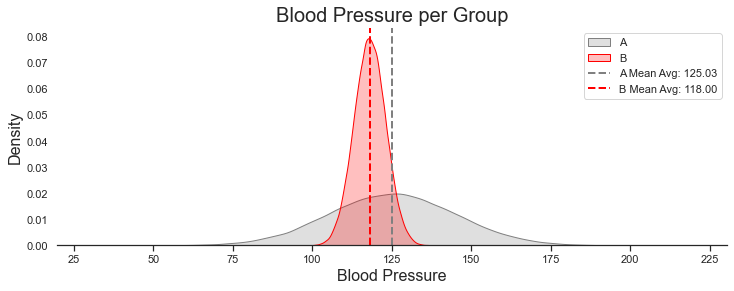

In [36]:
# Compare distributions of means between the two groups
plt.figure(figsize=(12, 4))
sns.kdeplot(welch_t_test_data['Group A'], label='A', fill = True, color = 'grey' , clip=(0, np.inf))
sns.kdeplot(welch_t_test_data['Group B'], label='B', fill = True, color = color, clip=(0, np.inf))
mean_group_a = welch_t_test_data['Group A'].mean()
mean_group_b = welch_t_test_data['Group B'].mean()
plt.axvline(mean_group_a, color='grey', linestyle='dashed', linewidth=2, label=f'A Mean Avg: {mean_group_a:.2f}')
plt.axvline(mean_group_b, color=color, linestyle='dashed', linewidth=2, label=f'B Mean Avg: {mean_group_b:.2f}')
plt.title('Blood Pressure per Group', fontsize = 20)
plt.xlabel('Blood Pressure', fontsize=16);
plt.ylabel('Density', fontsize=16)
plt.tick_params(left=False,bottom=True,labelleft=True,labelbottom=True)
plt.legend()
plt.show()